In [1]:
!pip install htsprophet

In [2]:
!pip install scikit-hts

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandasql as ps

from datetime import datetime


from htsprophet.hts import hts, orderHier, makeWeekly
from htsprophet.htsPlot import plotNode, plotChild, plotNodeComponents

from hts.hierarchy import HierarchyTree
from hts import HTSRegressor

# import chart_studio.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from plotly import figure_factory as FF
import plotly.express as px

from fbprophet import Prophet

import matplotlib
import matplotlib.pyplot as plt

import warnings

# warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2


%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mock-data/MOCK_DATA.csv


In [4]:
df = pd.read_csv("../input/mock-data/MOCK_DATA.csv")
df

,start_at,market_name,neighborhood_name,orders_count,distinct_count_fulfilled_shoppers
0,2017-03-08T18:53:58Z,California,Inglewood,1,6
1,2017-03-27T23:20:20Z,California,Los Angeles,2,6
2,2017-03-22T21:35:16Z,California,Stockton,3,1
3,2017-03-23T06:13:34Z,Pennsylvania,Bethlehem,3,6
4,2017-03-30T09:23:39Z,California,Sacramento,4,3
...,...,...,...,...,...
995,2017-03-29T18:00:03Z,Pennsylvania,Lancaster,3,3
996,2017-03-16T20:34:06Z,Pennsylvania,Philadelphia,3,5
997,2017-03-01T06:56:06Z,California,Sacramento,2,1
998,2017-03-31T17:22:40Z,California,Santa Barbara,2,1


In [5]:
#Format time column.
df["start_at"] = pd.to_datetime(df['start_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

# Demand HTS

In [6]:
demand_df = df.iloc[:,:-1]
demand_df.head()

,start_at,market_name,neighborhood_name,orders_count
0,2017-03-08 18:53:58,California,Inglewood,1
1,2017-03-27 23:20:20,California,Los Angeles,2
2,2017-03-22 21:35:16,California,Stockton,3
3,2017-03-23 06:13:34,Pennsylvania,Bethlehem,3
4,2017-03-30 09:23:39,California,Sacramento,4


In [7]:
#For later use:
supply_df = df.drop(columns=['orders_count'])
supply_df.head()

,start_at,market_name,neighborhood_name,distinct_count_fulfilled_shoppers
0,2017-03-08 18:53:58,California,Inglewood,6
1,2017-03-27 23:20:20,California,Los Angeles,6
2,2017-03-22 21:35:16,California,Stockton,1
3,2017-03-23 06:13:34,Pennsylvania,Bethlehem,6
4,2017-03-30 09:23:39,California,Sacramento,3


In order to transpose groups in market and neighborhood columns, will use htsprophet library.

In [8]:
df2, nodes = orderHier(demand_df,1,2)
df2

,time,Total,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,...,New York_New Castle,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael
0,2017-03-08 18:53:58,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2017-03-27 23:20:20,2,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2017-03-22 21:35:16,3,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2017-03-23 06:13:34,3,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2017-03-30 09:23:39,4,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2017-03-29 18:00:03,3,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
995,2017-03-16 20:34:06,3,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
996,2017-03-01 06:56:06,2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
997,2017-03-31 17:22:40,2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Resulting transpositions have incorrect summations. Below cells help corrrect for it.

In [9]:
California = ['California_Inglewood',
  'California_Los Angeles',
  'California_Stockton',
  'California_Bethlehem',
  'California_Sacramento',
  'California_Simi Valley',
  'California_Albany',
  'California_Modesto',
  'California_San Francisco',
  'California_Lancaster',
  'California_York',
  'California_Oakland',
  'California_Irvine',
  'California_San Jose',
  'California_Chula Vista',
  'California_Mountain View',
  'California_San Diego',
  'California_North Hollywood',
  'California_White Plains',
  'California_New York City',
  'California_Santa Cruz',
  'California_Hayward',
  'California_Erie',
  'California_Harrisburg',
  'California_Buffalo',
  'California_Whittier',
  'California_Philadelphia',
  'California_Torrance',
  'California_Bakersfield',
  'California_Salinas',
  'California_Bronx',
  'California_Pittsburgh',
  'California_Great Neck',
  'California_Long Beach',
  'California_Mount Vernon',
  'California_New Hyde Park',
  'California_Utica',
  'California_Anaheim',
  'California_Moreno Valley',
  'California_Chico',
  'California_Brooklyn',
  'California_Rochester',
  'California_San Bernardino',
  'California_Fresno',
  'California_Santa Monica',
  'California_Glendale',
  'California_Oceanside',
  'California_Reading',
  'California_Jamaica',
  'California_Pomona',
  'California_Orange',
  'California_Pasadena',
  'California_Garden Grove',
  'California_Santa Clara',
  'California_Syracuse',
  'California_Johnstown',
  'California_Elmira',
  'California_Santa Barbara',
  'California_Scranton',
  'California_Valley Forge',
  'California_Flushing',
  'California_Schenectady',
  'California_Visalia',
  'California_Wilkes Barre',
  'California_Van Nuys',
  'California_Oxnard',
  'California_Santa Rosa',
  'California_Burbank',
  'California_Berkeley',
  'California_South Lake Tahoe',
  'California_Corona',
  'California_Huntington Beach',
  'California_Petaluma',
  'California_Riverside',
  'California_Levittown',
  'California_Richmond',
  'California_Sunnyvale',
  'California_Escondido',
  'California_Allentown',
  'California_Ventura',
  'California_San Mateo',
  'California_Northridge',
  'California_Palmdale',
  'California_Staten Island',
  'California_Brea',
  'California_Mc Keesport',
  'California_Concord',
  'California_Yonkers',
  'California_New Castle',
  'California_Palo Alto',
  'California_Fullerton',
  'California_Port Washington',
  'California_San Luis Obispo',
  'California_Carlsbad',
  'California_Hicksville',
  'California_Santa Ana',
  'California_Alhambra',
  'California_San Rafael']

In [10]:
Pennsylvania = ['Pennsylvania_Inglewood',
  'Pennsylvania_Los Angeles',
  'Pennsylvania_Stockton',
  'Pennsylvania_Bethlehem',
  'Pennsylvania_Sacramento',
  'Pennsylvania_Simi Valley',
  'Pennsylvania_Albany',
  'Pennsylvania_Modesto',
  'Pennsylvania_San Francisco',
  'Pennsylvania_Lancaster',
  'Pennsylvania_York',
  'Pennsylvania_Oakland',
  'Pennsylvania_Irvine',
  'Pennsylvania_San Jose',
  'Pennsylvania_Chula Vista',
  'Pennsylvania_Mountain View',
  'Pennsylvania_San Diego',
  'Pennsylvania_North Hollywood',
  'Pennsylvania_White Plains',
  'Pennsylvania_New York City',
  'Pennsylvania_Santa Cruz',
  'Pennsylvania_Hayward',
  'Pennsylvania_Erie',
  'Pennsylvania_Harrisburg',
  'Pennsylvania_Buffalo',
  'Pennsylvania_Whittier',
  'Pennsylvania_Philadelphia',
  'Pennsylvania_Torrance',
  'Pennsylvania_Bakersfield',
  'Pennsylvania_Salinas',
  'Pennsylvania_Bronx',
  'Pennsylvania_Pittsburgh',
  'Pennsylvania_Great Neck',
  'Pennsylvania_Long Beach',
  'Pennsylvania_Mount Vernon',
  'Pennsylvania_New Hyde Park',
  'Pennsylvania_Utica',
  'Pennsylvania_Anaheim',
  'Pennsylvania_Moreno Valley',
  'Pennsylvania_Chico',
  'Pennsylvania_Brooklyn',
  'Pennsylvania_Rochester',
  'Pennsylvania_San Bernardino',
  'Pennsylvania_Fresno',
  'Pennsylvania_Santa Monica',
  'Pennsylvania_Glendale',
  'Pennsylvania_Oceanside',
  'Pennsylvania_Reading',
  'Pennsylvania_Jamaica',
  'Pennsylvania_Pomona',
  'Pennsylvania_Orange',
  'Pennsylvania_Pasadena',
  'Pennsylvania_Garden Grove',
  'Pennsylvania_Santa Clara',
  'Pennsylvania_Syracuse',
  'Pennsylvania_Johnstown',
  'Pennsylvania_Elmira',
  'Pennsylvania_Santa Barbara',
  'Pennsylvania_Scranton',
  'Pennsylvania_Valley Forge',
  'Pennsylvania_Flushing',
  'Pennsylvania_Schenectady',
  'Pennsylvania_Visalia',
  'Pennsylvania_Wilkes Barre',
  'Pennsylvania_Van Nuys',
  'Pennsylvania_Oxnard',
  'Pennsylvania_Santa Rosa',
  'Pennsylvania_Burbank',
  'Pennsylvania_Berkeley',
  'Pennsylvania_South Lake Tahoe',
  'Pennsylvania_Corona',
  'Pennsylvania_Huntington Beach',
  'Pennsylvania_Petaluma',
  'Pennsylvania_Riverside',
  'Pennsylvania_Levittown',
  'Pennsylvania_Richmond',
  'Pennsylvania_Sunnyvale',
  'Pennsylvania_Escondido',
  'Pennsylvania_Allentown',
  'Pennsylvania_Ventura',
  'Pennsylvania_San Mateo',
  'Pennsylvania_Northridge',
  'Pennsylvania_Palmdale',
  'Pennsylvania_Staten Island',
  'Pennsylvania_Brea',
  'Pennsylvania_Mc Keesport',
  'Pennsylvania_Concord',
  'Pennsylvania_Yonkers',
  'Pennsylvania_New Castle',
  'Pennsylvania_Palo Alto',
  'Pennsylvania_Fullerton',
  'Pennsylvania_Port Washington',
  'Pennsylvania_San Luis Obispo',
  'Pennsylvania_Carlsbad',
  'Pennsylvania_Hicksville',
  'Pennsylvania_Santa Ana',
  'Pennsylvania_Alhambra',
  'Pennsylvania_San Rafael']

In [11]:
New_York = ['New York_Inglewood',
  'New York_Los Angeles',
  'New York_Stockton',
  'New York_Bethlehem',
  'New York_Sacramento',
  'New York_Simi Valley',
  'New York_Albany',
  'New York_Modesto',
  'New York_San Francisco',
  'New York_Lancaster',
  'New York_York',
  'New York_Oakland',
  'New York_Irvine',
  'New York_San Jose',
  'New York_Chula Vista',
  'New York_Mountain View',
  'New York_San Diego',
  'New York_North Hollywood',
  'New York_White Plains',
  'New York_New York City',
  'New York_Santa Cruz',
  'New York_Hayward',
  'New York_Erie',
  'New York_Harrisburg',
  'New York_Buffalo',
  'New York_Whittier',
  'New York_Philadelphia',
  'New York_Torrance',
  'New York_Bakersfield',
  'New York_Salinas',
  'New York_Bronx',
  'New York_Pittsburgh',
  'New York_Great Neck',
  'New York_Long Beach',
  'New York_Mount Vernon',
  'New York_New Hyde Park',
  'New York_Utica',
  'New York_Anaheim',
  'New York_Moreno Valley',
  'New York_Chico',
  'New York_Brooklyn',
  'New York_Rochester',
  'New York_San Bernardino',
  'New York_Fresno',
  'New York_Santa Monica',
  'New York_Glendale',
  'New York_Oceanside',
  'New York_Reading',
  'New York_Jamaica',
  'New York_Pomona',
  'New York_Orange',
  'New York_Pasadena',
  'New York_Garden Grove',
  'New York_Santa Clara',
  'New York_Syracuse',
  'New York_Johnstown',
  'New York_Elmira',
  'New York_Santa Barbara',
  'New York_Scranton',
  'New York_Valley Forge',
  'New York_Flushing',
  'New York_Schenectady',
  'New York_Visalia',
  'New York_Wilkes Barre',
  'New York_Van Nuys',
  'New York_Oxnard',
  'New York_Santa Rosa',
  'New York_Burbank',
  'New York_Berkeley',
  'New York_South Lake Tahoe',
  'New York_Corona',
  'New York_Huntington Beach',
  'New York_Petaluma',
  'New York_Riverside',
  'New York_Levittown',
  'New York_Richmond',
  'New York_Sunnyvale',
  'New York_Escondido',
  'New York_Allentown',
  'New York_Ventura',
  'New York_San Mateo',
  'New York_Northridge',
  'New York_Palmdale',
  'New York_Staten Island',
  'New York_Brea',
  'New York_Mc Keesport',
  'New York_Concord',
  'New York_Yonkers',
  'New York_New Castle',
  'New York_Palo Alto',
  'New York_Fullerton',
  'New York_Port Washington',
  'New York_San Luis Obispo',
  'New York_Carlsbad',
  'New York_Hicksville',
  'New York_Santa Ana',
  'New York_Alhambra',
  'New York_San Rafael']

In [12]:
#Need to correct sums for Total and each state

total_list = demand_df.market_name.unique()

#drop columns and readd them with correct sums across rows (neighborhoods for states and states for total)
df2 = df2.drop(columns = ['Total', 'California', 'Pennsylvania', 'New York'])

#Add in right sums for col's
df2['California'] = df2[California].sum(axis=1)
df2['Pennsylvania'] = df2[Pennsylvania].sum(axis=1)
df2['New York'] = df2[New_York].sum(axis=1)
df2['Total'] = df2[total_list].sum(axis=1)

df2

,time,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,California_Simi Valley,California_Albany,California_Modesto,California_San Francisco,...,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael,California,Pennsylvania,New York,Total
0,2017-03-08 18:53:58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,98.0,98.0,98.0,294.0
1,2017-03-27 23:20:20,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,99.0,98.0,98.0,295.0
2,2017-03-22 21:35:16,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,100.0,98.0,98.0,296.0
3,2017-03-23 06:13:34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,98.0,100.0,98.0,296.0
4,2017-03-30 09:23:39,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,101.0,98.0,98.0,297.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2017-03-29 18:00:03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,98.0,100.0,98.0,296.0
995,2017-03-16 20:34:06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,98.0,100.0,98.0,296.0
996,2017-03-01 06:56:06,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,99.0,98.0,98.0,295.0
997,2017-03-31 17:22:40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,99.0,98.0,98.0,295.0


In [13]:
#Reorder columns
df2 = df2[['time','Total','California', 'Pennsylvania','New York'] + [c for c in df2 if c not in ['time','Total','California', 'Pennsylvania','New York']]]
df2.head()

,time,Total,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,...,New York_New Castle,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael
0,2017-03-08 18:53:58,294.0,98.0,98.0,98.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2017-03-27 23:20:20,295.0,99.0,98.0,98.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2017-03-22 21:35:16,296.0,100.0,98.0,98.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2017-03-23 06:13:34,296.0,98.0,100.0,98.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2017-03-30 09:23:39,297.0,101.0,98.0,98.0,1.0,1.0,1.0,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
#Moving total to end of DF
df2 = df2[[c for c in df2 if c not in ['Total']] 
       + ['Total']]

#Rename Total to total:
df2.rename({'Total': 'total'}, axis=1, inplace=True)

#Set time column as idx
df2 = df2.set_index('time')
df2

,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,California_Simi Valley,California_Albany,...,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael,total
time,,,,,,,,,,,,,,,,,,,,,
2017-03-08 18:53:58,98.0,98.0,98.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,294.0
2017-03-27 23:20:20,99.0,98.0,98.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,295.0
2017-03-22 21:35:16,100.0,98.0,98.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,296.0
2017-03-23 06:13:34,98.0,100.0,98.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,296.0
2017-03-30 09:23:39,101.0,98.0,98.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,297.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-29 18:00:03,98.0,100.0,98.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,296.0
2017-03-16 20:34:06,98.0,100.0,98.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,296.0
2017-03-01 06:56:06,99.0,98.0,98.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,295.0


In [15]:
#Putting hierarchy together
markets = demand_df.market_name.unique()
hierarchy = {'total' : list(markets)}
for m in markets:
    for n in list(df2):
        neigh_name = m + '_'
        hierarchy[m] = [n for n in list(df2) if n.startswith(neigh_name)]
hierarchy

{'total': ['California', 'Pennsylvania', 'New York'],
 'California': ['California_Inglewood',
  'California_Los Angeles',
  'California_Stockton',
  'California_Bethlehem',
  'California_Sacramento',
  'California_Simi Valley',
  'California_Albany',
  'California_Modesto',
  'California_San Francisco',
  'California_Lancaster',
  'California_York',
  'California_Oakland',
  'California_Irvine',
  'California_San Jose',
  'California_Chula Vista',
  'California_Mountain View',
  'California_San Diego',
  'California_North Hollywood',
  'California_White Plains',
  'California_New York City',
  'California_Santa Cruz',
  'California_Hayward',
  'California_Erie',
  'California_Harrisburg',
  'California_Buffalo',
  'California_Whittier',
  'California_Philadelphia',
  'California_Torrance',
  'California_Bakersfield',
  'California_Salinas',
  'California_Bronx',
  'California_Pittsburgh',
  'California_Great Neck',
  'California_Long Beach',
  'California_Mount Vernon',
  'California_N

In [16]:
#A look at hierarchical structure

ht = HierarchyTree.from_nodes(hierarchy, df2)
ht

- total
   |- California
   |  |- California_Inglewood
   |  |- California_Los Angeles
   |  |- California_Stockton
   |  |- California_Bethlehem
   |  |- California_Sacramento
   |  |- California_Simi Valley
   |  |- California_Albany
   |  |- California_Modesto
   |  |- California_San Francisco
   |  |- California_Lancaster
   |  |- California_York
   |  |- California_Oakland
   |  |- California_Irvine
   |  |- California_San Jose
   |  |- California_Chula Vista
   |  |- California_Mountain View
   |  |- California_San Diego
   |  |- California_North Hollywood
   |  |- California_White Plains
   |  |- California_New York City
   |  |- California_Santa Cruz
   |  |- California_Hayward
   |  |- California_Erie
   |  |- California_Harrisburg
   |  |- California_Buffalo
   |  |- California_Whittier
   |  |- California_Philadelphia
   |  |- California_Torrance
   |  |- California_Bakersfield
   |  |- California_Salinas
   |  |- California_Bronx
   |  |- California_Pittsburgh
   |  |- Cali

In [17]:
#Have to change date column to date only (no time component) so error is not thrown when predictions are made
df2 = df2.resample("D").sum()
df2

,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,California_Simi Valley,California_Albany,...,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael,total
time,,,,,,,,,,,,,,,,,,,,,
2017-03-01,3748.0,3738.0,3734.0,38.0,38.0,38.0,38.0,41.0,38.0,38.0,...,38.0,38.0,39.0,38.0,38.0,38.0,38.0,38.0,38.0,11220.0
2017-03-02,3662.0,3634.0,3630.0,40.0,38.0,37.0,37.0,44.0,37.0,37.0,...,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,10926.0
2017-03-03,3260.0,3248.0,3242.0,33.0,35.0,33.0,33.0,36.0,33.0,33.0,...,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,9750.0
2017-03-04,2570.0,2560.0,2567.0,26.0,27.0,27.0,26.0,26.0,27.0,26.0,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,7697.0
2017-03-05,3774.0,3726.0,3735.0,38.0,45.0,38.0,38.0,39.0,38.0,38.0,...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,11235.0
2017-03-06,4351.0,4334.0,4328.0,44.0,46.0,47.0,44.0,49.0,44.0,44.0,...,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,13013.0
2017-03-07,2269.0,2266.0,2261.0,26.0,23.0,23.0,23.0,23.0,23.0,23.0,...,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,6796.0
2017-03-08,3949.0,3930.0,3942.0,41.0,46.0,40.0,40.0,47.0,40.0,40.0,...,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,11821.0
2017-03-09,3472.0,3440.0,3442.0,35.0,38.0,35.0,35.0,35.0,35.0,35.0,...,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,10354.0


In [18]:
clf = HTSRegressor(model='prophet', revision_method='OLS')
model = clf.fit(df2, hierarchy)

Fitting models: 100%|██████████| 10/10 [00:40<00:00,  4.07s/it]


In [19]:
#test predictions
preds = model.predict(steps_ahead = 30) #on top of historical data predictions, 30 day horizon is added

Fitting models: 100%|██████████| 10/10 [05:43<00:00, 34.35s/it]


In [20]:
preds.head()

,total,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,California_Simi Valley,...,New York_New Castle,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael
2017-03-01,10469.211802,3506.003247,3482.400000,3480.808555,36.577614,38.880572,35.860668,35.459835,40.135028,35.551726,...,36.076477,36.255974,35.423771,35.423771,35.423771,35.423771,35.423771,35.423771,35.423771,35.423771
2017-03-02,11408.615936,3818.625710,3795.506910,3794.483316,39.572928,39.479659,38.860432,38.648081,40.933205,38.738805,...,38.713427,38.871195,38.651752,38.651752,38.651752,38.651752,38.651752,38.651752,38.651752,38.651752
2017-03-03,9640.273628,3225.428306,3206.485498,3208.359824,32.971525,35.672225,32.651704,32.658496,33.530926,32.748676,...,32.695317,32.898265,32.650462,32.650462,32.650462,32.650462,32.650462,32.650462,32.650462,32.650462
2017-03-04,9128.119505,3054.911343,3035.477230,3037.730932,31.880270,33.253714,31.888679,30.903223,32.498795,31.218982,...,32.169933,31.581189,30.893069,30.893069,30.893069,30.893069,30.893069,30.893069,30.893069,30.893069
2017-03-05,8974.577030,3010.814255,2981.374887,2982.387889,30.626333,33.499140,30.383761,30.399995,31.494605,30.465996,...,30.917448,30.584604,30.392195,30.392195,30.392195,30.392195,30.392195,30.392195,30.392195,30.392195


In [21]:
#Actual values + resetting index to actual column for plotting
df2.reset_index(inplace=True)
df2.head(5)

,time,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,California_Simi Valley,...,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael,total
0,2017-03-01,3748.0,3738.0,3734.0,38.0,38.0,38.0,38.0,41.0,38.0,...,38.0,38.0,39.0,38.0,38.0,38.0,38.0,38.0,38.0,11220.0
1,2017-03-02,3662.0,3634.0,3630.0,40.0,38.0,37.0,37.0,44.0,37.0,...,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,10926.0
2,2017-03-03,3260.0,3248.0,3242.0,33.0,35.0,33.0,33.0,36.0,33.0,...,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,9750.0
3,2017-03-04,2570.0,2560.0,2567.0,26.0,27.0,27.0,26.0,26.0,27.0,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,7697.0
4,2017-03-05,3774.0,3726.0,3735.0,38.0,45.0,38.0,38.0,39.0,38.0,...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,11235.0


In [22]:
preds.reset_index(inplace=True)
preds = preds.rename(columns = {'index':'time'})

In [23]:
#Extracting data prior to horizon/future dates to compare predictoins with historical data
preds2 = preds.head(31)
preds2.head(2)

,time,total,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,...,New York_New Castle,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael
0,2017-03-01,10469.211802,3506.003247,3482.40000,3480.808555,36.577614,38.880572,35.860668,35.459835,40.135028,...,36.076477,36.255974,35.423771,35.423771,35.423771,35.423771,35.423771,35.423771,35.423771,35.423771
1,2017-03-02,11408.615936,3818.625710,3795.50691,3794.483316,39.572928,39.479659,38.860432,38.648081,40.933205,...,38.713427,38.871195,38.651752,38.651752,38.651752,38.651752,38.651752,38.651752,38.651752,38.651752


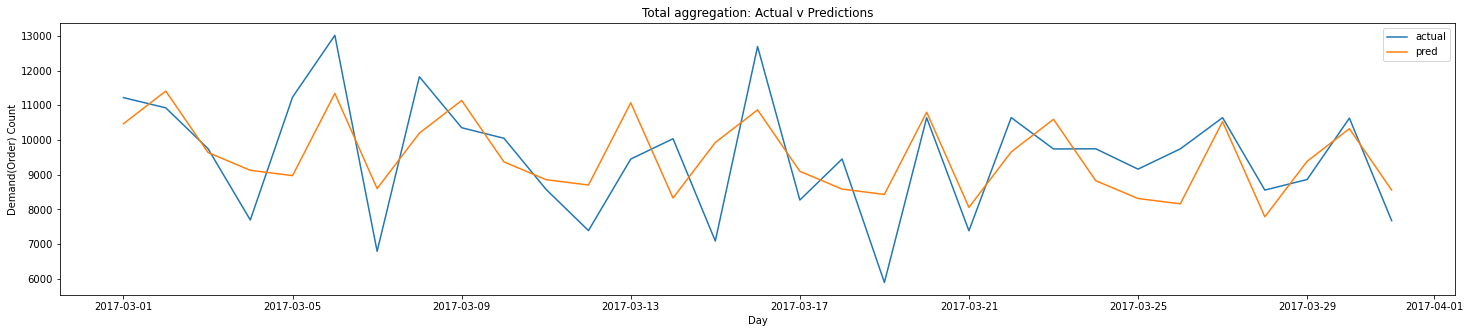

In [24]:
%matplotlib inline

x = df2['time']
y = df2['total']
z = preds2['total']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('Total aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

We can see here for Total aggregation predictions, Prophet is conservative by estimating near middle lineof actual values. Let's take more samples from our hierarchy to see how other levels were predicted (markets and neighborhoods).

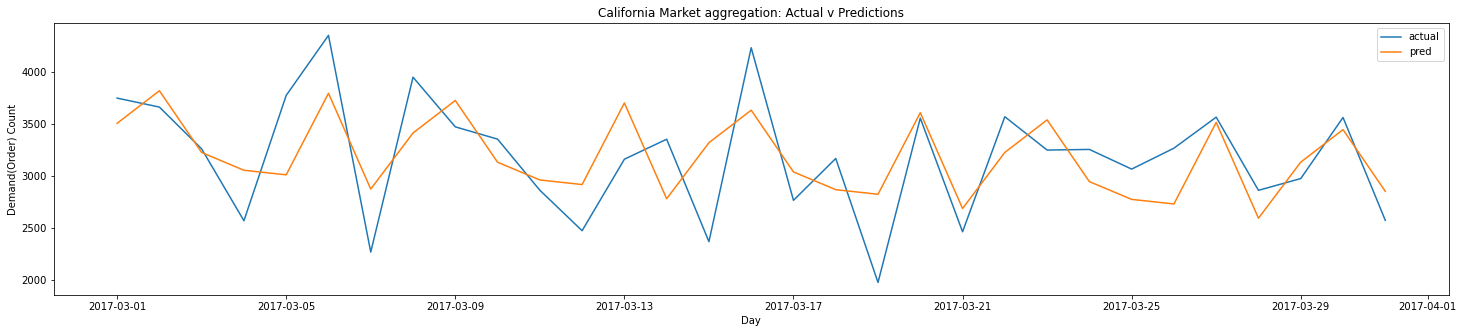

In [25]:
x = df2['time']
y = df2['California']
z = preds2['California']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('California Market aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

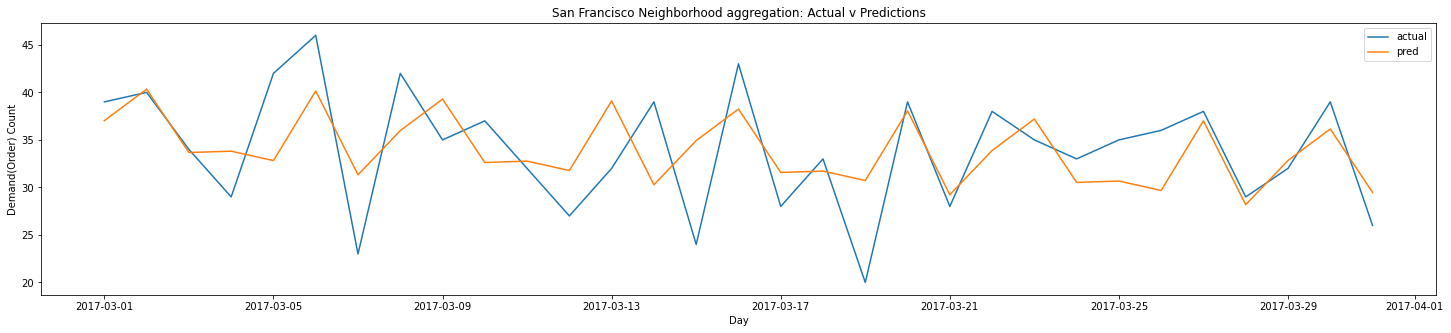

In [26]:
x = df2['time']
y = df2['California_San Francisco']
z = preds2['California_San Francisco']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('San Francisco Neighborhood aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

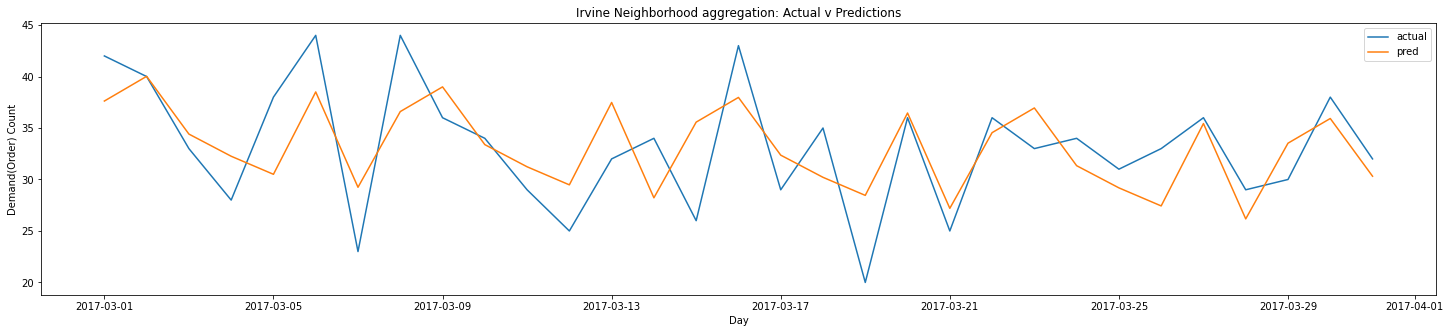

In [27]:
x = df2['time']
y = df2['California_Irvine']
z = preds2['California_Irvine']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('Irvine Neighborhood aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

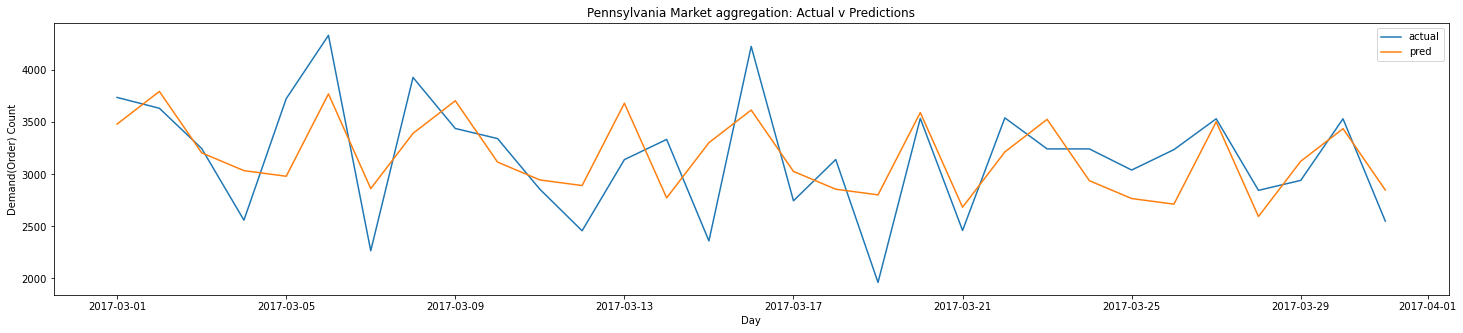

In [28]:
x = df2['time']
y = df2['Pennsylvania']
z = preds2['Pennsylvania']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('Pennsylvania Market aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

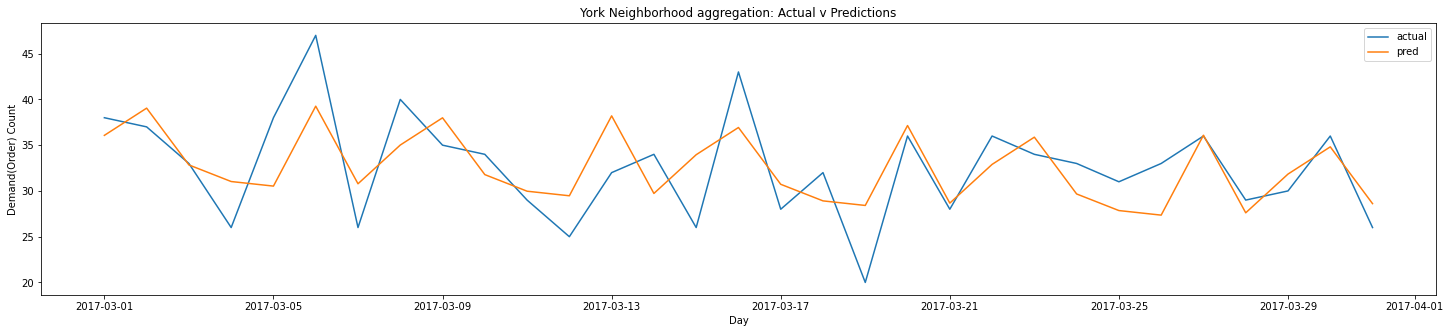

In [29]:
x = df2['time']
y = df2['Pennsylvania_York']
z = preds2['Pennsylvania_York']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('York Neighborhood aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

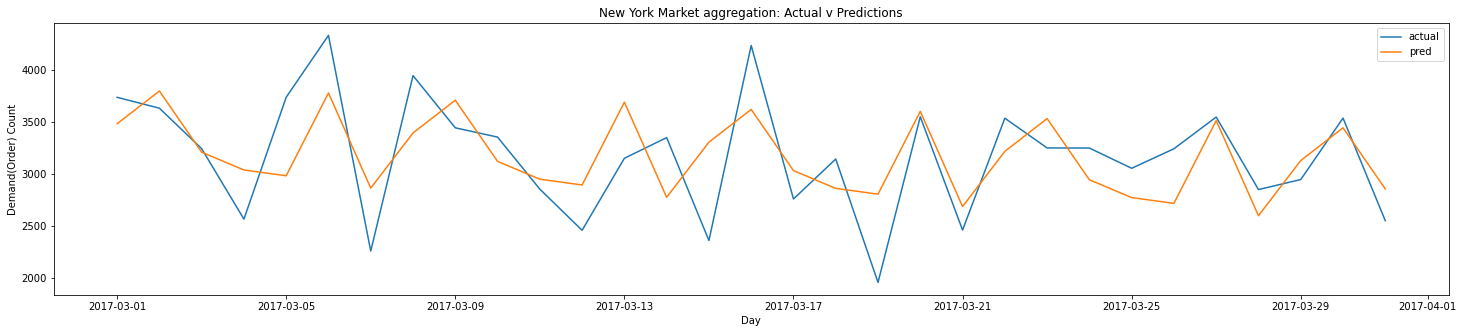

In [30]:
x = df2['time']
y = df2['New York']
z = preds2['New York']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('New York Market aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

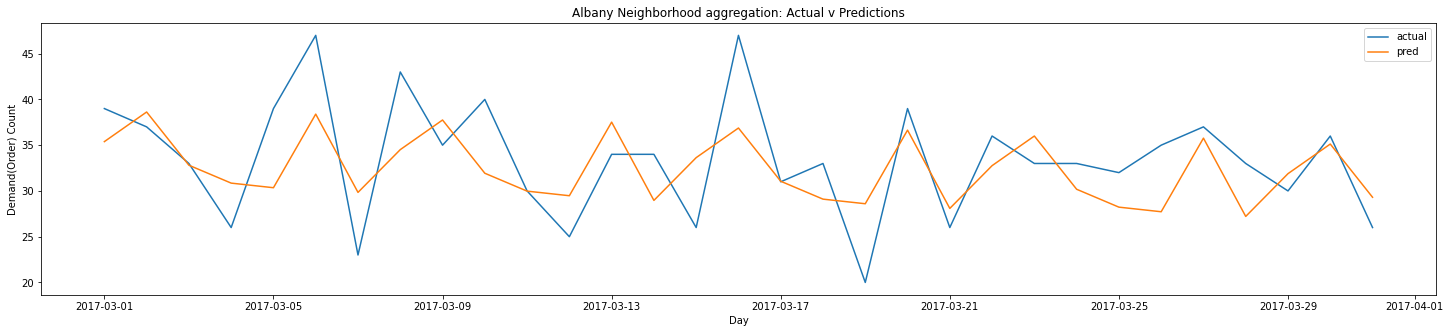

In [31]:
x = df2['time']
y = df2['New York_Albany']
z = preds2['New York_Albany']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('Albany Neighborhood aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

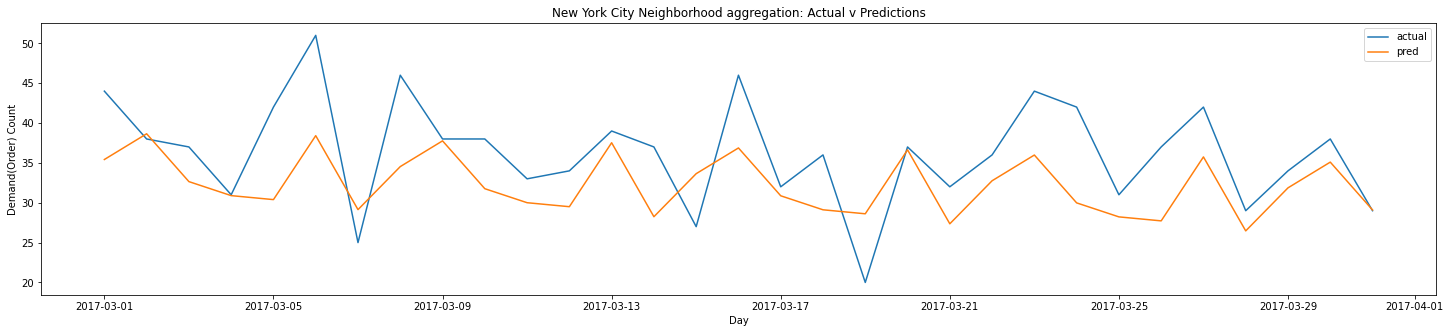

In [32]:
x = df2['time']
y = df2['New York_New York City']
z = preds2['New York_New York City']


fig, ax = plt.subplots(figsize=(25, 5))


ax.plot(x,y)
ax.plot(x,z)


ax.set_title('New York City Neighborhood aggregation: Actual v Predictions')
ax.legend(['actual','pred'])
ax.xaxis.set_label_text('Day')
ax.yaxis.set_label_text('Demand(Order) Count')


plt.show()

Overall, the demand curves at all levels: total, market and neighborhoods have similar trends due to the data not being very interesting (one month's worth and dummy data with small range of numbers). Something to note though is that neighborhood forecasts were the closest to actual due to it being the smallest of aggregates when compared to top level total aggregate. Let's move onto Supply forecasting at the same level using the same scikit-hts package.